# Custom Iterators

kawin currently comes with two built-in iterators when solving a model: Explicit Euler and 4th order Runga Kutta. However, custom iterators can be made and used in the solve function.

We'll use the Al-Zr system from the Binary Precipitation example as a use-case.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from kawin.thermo import BinaryThermodynamics
from kawin.precipitation import PrecipitateModel
from kawin.precipitation import MatrixParameters, PrecipitateParameters

#Set up thermodynamics
therm = BinaryThermodynamics('AlScZr.tdb', ['AL', 'ZR'], ['FCC_A1', 'AL3ZR'])
therm.setGuessComposition(0.24)
diff = lambda T: 0.0768 * np.exp(-242000 / (8.314 * T))
therm.setDiffusivity(diff, 'FCC_A1')

a = 0.405e-9
matrix = MatrixParameters(['ZR'])
matrix.initComposition = 4e-3
matrix.volume.setVolume(a**3, 'VA', 4)
matrix.nucleationSites.setNucleationDensity(grainSize=1, dislocationDensity=1e15)

precipitate = PrecipitateParameters('AL3ZR')
precipitate.gamma = 0.1
precipitate.volume.setVolume(a**3, 'VA', 4)
precipitate.nucleation.setNucleationType('dislocations')

temperature = 450+273.15

Let's solve the model using the Explicit Euler method for a comparison.

In [2]:
from kawin.solver import explicitEulerIterator

#Set up model with parameters
modelEuler = PrecipitateModel(matrix, precipitate, therm, temperature)
modelEuler.solve(500*3600, iterator=explicitEulerIterator, verbose=True, vIt=5000)

C:\Users\ury3\OneDrive - LLNL\Documents\Projects\U-C Modeling\kawin-development\kawin\kawin\precipitation\NucleationRate.py:190: RuntimeWarning: divide by zero encountered in divide
  incubationTime = np.amin([np.exp(-tau[indices] / time), np.ones(tau[indices].shape)], axis=0)


N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
0	0.0e+00		0.0		723		0.4000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	0.000e+00		0.0000		0.0000e+00	5.7737e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
3725	1.8e+06		9.9		723		0.0126

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	1.397e+22		1.5504		6.0868e-09	3.2941e+02



The custom iteration function will need to take in the following parameters:
- f : function that takes in ($t$, $X$) and returns $dX/dt$ (and $\Delta t$)
- t : current time (float)
- X : current $X$ (list - can be a nested list)
- updateX : function that takes in ($X$, $dX/dt$ and $\Delta t$) and returns $X_{new}$

Notes:
- The functions f and updateX are implemented by the Solver object, so these do not need to be implemented
- While $X_{new}$ can be found by $X + dX/dt * \Delta t$, the updateX function will apply any corrections needed to $dX/dt$ defined by the GenericModel to avoid improper values of $X_{new}$

We'll create a custom function that uses the Midpoint iterative scheme. This goes by:
$$ X_{n+1} = X_n + \Delta t * f\left(t + \frac{\Delta t}{2}, X_n + \frac{\Delta t}{2} * \frac{dX_n}{dt}\right)  $$

In [3]:
def midpointIterator(f, t, Xn, updateX):
    #Get dXdt at Xn along with dt
    dXdt, dt = f(t, Xn, True)

    #Calculate X + dXdt * dt/2 and get dXdt at midpoint
    Xmid = updateX(Xn, dXdt, dt/2)
    dXdt_mid = f(t, Xmid)

    #Calculate X + dXdt_mid * dt
    return updateX(Xn, dXdt_mid, dt), dt

We can solve the model with this new iteration by replacing solverType with this function.

In [4]:
#Set up new model with same parameters
modelMidpoint = PrecipitateModel(matrix, precipitate, therm, temperature)
modelMidpoint.solve(500*3600, iterator=midpointIterator, verbose=True, vIt=5000)

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
0	0.0e+00		0.0		723		0.4000

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	0.000e+00		0.0000		0.0000e+00	5.7737e+03

N	Time (s)	Sim Time (s)	Temperature (K)	Matrix Comp
3647	1.8e+06		17.0		723		0.0126

	Phase	Prec Density (#/m3)	Volume Frac	Avg Radius (m)	Driving Force (J/mol)
	AL3ZR	1.386e+22		1.5505		6.0984e-09	3.2681e+02



Then we could compare the results from the Explicit Euler with the Midpoint iterators.

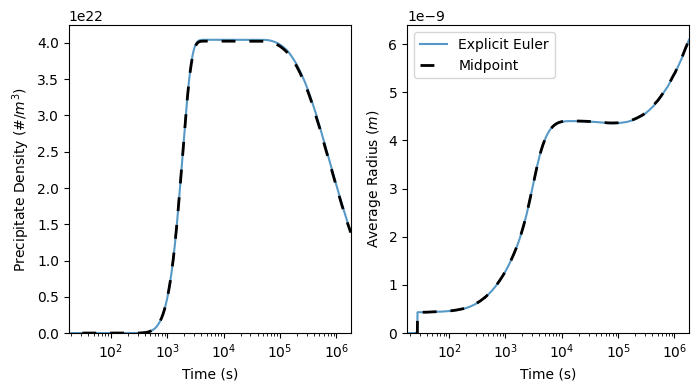

In [5]:
from kawin.precipitation.Plot import plotPrecipitateDensity, plotAverageRadius

fig, ax = plt.subplots(1, 2, figsize=(8,4))

plotPrecipitateDensity(modelEuler, ax=ax[0], label='Explicit Euler', alpha=0.75)
plotPrecipitateDensity(modelMidpoint, ax=ax[0], label='Midpoint', color='k', linestyle=(0,(5,5)), linewidth=2)

plotAverageRadius(modelEuler, ax=ax[1], label='Explicit Euler', alpha=0.75)
plotAverageRadius(modelMidpoint, ax=ax[1], label='Midpoint', color='k', linestyle=(0,(5,5)), linewidth=2)

ax[1].legend()